<h1>Data generation for the time of flight study</h1>

We want to study the time of flight for waves propagating in the X-mode in magnetised plasma. For this purpose we will be using the ```WavesPlasma``` library and we will be often taking after the ```X-mode Propagation Study``` notebook.

In [1]:
import numpy as np
import cmath as cm

from scipy.fft import fft,fftfreq
from scipy.interpolate import make_smoothing_spline

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import clear_output

import copy
from timeit import default_timer as timer
import pandas as pd

np.random.seed(2024061) # For reproducibility

import import_ipynb
from WavesPlasma import *

Nx     = 2100
p0plas = 90
k00    = 0.025
ν      = 84 
wpe2_,wc_ = freq_dicts(Nx,k00,p0plas)
# Profile reconstruction
β      = 27.9

importing Jupyter notebook from WavesPlasma.ipynb


<h2>Data generation</h2>

<h3>Single Run</h3>

In [2]:
λinσ = 150 
Nt   = int(np.ceil(10*λinσ*np.pi/k00))*3   #k00<ωco_[γidx]

# -- Changing with iteration

xc_ = p0plas+np.array([100])

γnum=10
γmax=90/32

γ_ = np.logspace(-2,0,γnum)*γmax

plas_ = [linearPlasma_domain(γ,β) for γ in γ_]
wco_ = np.array([plas.wco_up(xc_[0]) for plas in plas_])

In [3]:
wco_*(ν/k00)

array([86.91447936, 85.82563374, 85.15969818, 84.75549946, 84.5113431 ,
       84.36429944, 84.27590347, 84.2228226 , 84.19096938, 84.17186232])

Time iterations:  565488


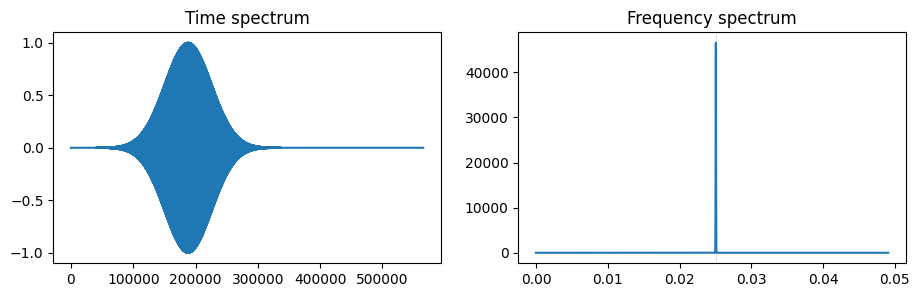

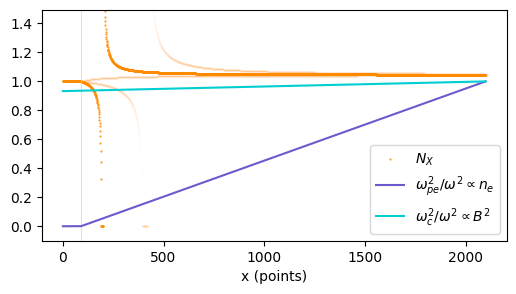

In [4]:
γidx = -1

σ    = λinσ*2*np.pi/wco_[γidx]

# -- We visually study the source --
print('Time iterations: ',Nt)

sourcet=[gaussSource(t,wco_[γidx],σ)*sinSource(t,wco_[γidx]) for t in range(Nt)]

plot_freqSpectrum(sourcet,Nt,128,ki=wco_[γidx])

kimin,kimax=freq_minmax(sourcet)
plas_[γidx].plot(wco_[γidx],kimin=kimin,kimax=kimax)

In [5]:
genData = 0

if genData:
    
    wv=wavePlasma(plas_[γidx],
                  ki = lambda t: k0i(t,wco_[γidx]),
                  sExc = lambda t,ki: gaussSource(t,ki,σ)*sinSource(t,ki)
                 )

    startRunTime=timer()
    wv.waveEvPlasma(Nt=Nt,Hist=True,plot=False)
    endRunTime=timer()

    print("Total running time: %.3f"%(endRunTime-startRunTime))

In [6]:
folderpath = 'Results/linear/'
filename = 'Test_Timeflight.pickle'

if genData:
    df=pd.DataFrame({'xc':[xc_[γidx]],'gamma':[γ_[γidx]],'eta0':[wv.plasma.η0],'Source':[sourcet],
                     'Reflected':[wv.Hist[1][1]],'Transmitted':[wv.Hist[2][1]]})
    df.to_pickle(dataname)
#else:
    #df=pd.read_pickle(dataname)

In [ ]:
df=pd.read_pickle(dataname)
wco = linearPlasma_domain(df.loc[0].at['gamma'],β).wco_up(df.loc[0].at['xc'])

plot_TransReflect(df.loc[0].at['Transmitted'],df.loc[0].at['Reflected'])

print('Numerical time of flight:   '+str(time_of_flight(sourcet,ref,(True,False))))

<h3>Multiple Runs</h3>

We begin by setting the parameters for all the runs

In [8]:
# -- Fixed parameters for all simulations
γnum = 10
γmax = 90/32
γ_ = np.logspace(-2,0,γnum)*γmax

λinσ = 150 
σ    = 2*λinσ*np.pi/k00
Nt   = int(np.ceil(5*σ))*3   #k00<ωco_[γidx]

# -- Changing with iteration
xc_ = p0plas+np.array([100])


In [9]:
genData=0

if genData:
    
    folderpath = 'Results/linear/'
    filename   = 'beta27p9_'+str(λinσ)+'lam_eta_FlightTime.pickle'
    
    try: df = pd.read_pickle(folderpath+filename)
    except: 
        df = pd.DataFrame({'λinσ':[0],'xc':[0],'gamma':[0],'eta0':[0],'Source':[np.zeros(Nt)],
                         'Reflected':[np.zeros(Nt)],'Transmitted':[np.zeros(Nt)]})
        df.to_pickle(folderpath+filename)
        
    del(df)

    for xcidx in range(len(xc_)):
    
        # -- Cut-off frequencies --
        plas_ = [linearPlasma_domain(γ,β) for γ in γ_]
        wco_ = np.array([plas.wco_up(xcidx) for plas in plas_])

        
        for γidx in range(len(γ_)):
        
            print('\nγ  = %.4f\nη0 = %.4f'%(γ_[γidx],plas_[γidx].η0))

            # -- Source --
        
            σ=2*λinσ*np.pi/wco_[γidx]
        
            #### -- WAVE SIMULATION -- ####
        
            wv=wavePlasma(plas_[γidx],
                          ki = lambda t: k0i(t,wco_[γidx]),
                          sExc = lambda t,ki: gaussSource(t,ki,σ)*sinSource(t,ki)
                         )

            #startRunTime=timer()
            wv.waveEvPlasma(Nt=Nt,Hist=True,plot=False)
            #endRunTime=timer()

            #print("Total running time: %.3f"%(endRunTime-startRunTime))
        

            df=pd.read_pickle(filename)
            df.loc[len(df)]=[λinσ,xc_[xcidx],γ_[γidx],plas_[γidx].η0,
                             [wv.sExc(t,wv.ki(t)) for t in range(Nt)],
                             wv.Hist[1][1],wv.Hist[2][1]]
            df.to_pickle(filename)
            del(df)


<h3>Kinetic Study</h3>

We want to study the conservation or loss of kinetic energy in the plasma. To do that we are going to record the velocities over the complete plasma domain over a cyclotron period ($\frac{2\pi}{\omega_{c}}$) and average them. We will do so at two times: one when the gaussian peak has already entered into the plasma and again once the wave has been reflected (at the end of the simulation).

In [10]:
# -- Fixed parameters for all simulations
γnum = 10
γmax = 90/32

λinσ = 150 
σ    = 2*λinσ*np.pi/k00
Nt   = int(np.ceil(5*σ))*3   #k00<ωco_[γidx]

# -- Changing with iteration
xc_ = p0plas+np.array([0])

γ_ = np.logspace(-2,0,γnum)[[3,5,7,9]]*γmax

recordKinetic=[(int(7*σ),int(np.ceil(2*np.pi/k00))),
                           (Nt-int(np.ceil(2*np.pi/k00))-1,int(np.ceil(2*np.pi/k00)))]
print(recordKinetic)


[(263893, 252), (565235, 252)]


In [11]:
genData=0

if genData:

    folderpath = 'Results/linear/xc'+str(xc_[0]-p0plas)+'beta'+str_dclp(β)+'/'
    filename    = 'xc'+str(xc_[0]-p0plas)+'beta27p9_'+str(λinσ)+'lam_eta_Kinetic2.pickle'
    
    try: df = pd.read_pickle(folderpath+filename)
    except: 
        v_Kin0   = []
        for i in range(len(recordKinetic)): v_Kin0.append(np.zeros((recordKinetic[i][1],2,Nx)))
        df = pd.DataFrame({'λinσ':[0],'xc':[0],'gamma':[0],'eta0':[0],'Source':[np.zeros(Nt)],
                           'Reflected':[np.zeros(Nt)],'Transmitted':[np.zeros(Nt)],'KineticTime':[np.zeros((2,Nt))],
                           'recordKinetic':[np.zeros(np.shape(recordKinetic))],'KineticSpace':[v_Kin0]})
        df.to_pickle(folderpath+filename)
        
    del(df)


    for xcidx in range(len(xc_)):
    
        # -- Cut-off frequencies --
        plas_ = [linearPlasma_domain(γ,β) for γ in γ_]
        wco_ = np.array([plas.wco_up(xc_[xcidx]) for plas in plas_])
        
        for γidx in range(len(γ_)):
        
            print('\nγ  = %.4f\nη0 = %.4f'%(γ_[γidx],linearPlasma_domain(γ_[γidx],β).η0))

            # -- Source --
        
            σ=2*λinσ*np.pi/wco_[γidx]
            recordKinetic=[(int(7*σ),int(np.ceil(2*np.pi/wco_[γidx]))),
                           (Nt-int(np.ceil(2*np.pi/wco_[γidx]))-1,int(np.ceil(2*np.pi/wco_[γidx])))]
            print('recordKinetic = ',recordKinetic)

            sourcet=[gaussSource(t,wco_[γidx],σ)*sinSource(t,wco_[γidx]) for t in range(Nt)]
        
            #### -- WAVE SIMULATION -- ####

            # -- Running the simulation --

            wv=wavePlasma(plas_[γidx],
                          ki = lambda t: k0i(t,wco_[γidx]),
                          sExc = lambda t,ki: gaussSource(t,ki,σ)*sinSource(t,ki)
                         )

            #startRunTime=timer()
            v_Kin=wv.waveEvPlasma(Nt=Nt,Hist=True,plot=False,recordKinetic=recordKinetic)
            #endRunTime=timer()

            #print("Total running time: %.3f"%(endRunTime-startRunTime))
            
            
            df=pd.read_pickle(folderpath+filename)
            df.loc[len(df)]=[λinσ,xc_[xcidx],γ_[γidx],plas_[γidx].η0,
                             [wv.sExc(t,wv.ki(t)) for t in range(Nt)],
                             wv.Hist[1][1],wv.Hist[2][1],wv.Hist[3],
                             recordKinetic,v_Kin]
            df.to_pickle(folderpath+filename)
            del(df)
